# Практика 5

Студент группы ИКБО-27-22
Соловьев Иван Евгеньевич

# Импорты

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


from imblearn.over_sampling import SMOTE


import matplotlib as mpl
from matplotlib import pyplot as plt, pylab as pylab
import seaborn as sns


mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8, 6

## Задание 1
Найти данные для классификации. Данные в группе повторяться не должны. Предобработать данные, если это необходимо.

In [123]:
df = pd.read_csv('winequalityN.csv', index_col=False) # Загрузка сырых данных - датасета красных и белых вин

Информация о наборе данных:
Набор данных был загружен из репозитория машинного обучения UCI.

Два набора данных относятся к красному и белому вариантам португальского вина Винью Верде. Из соображений конфиденциальности и логистики доступны только физико-химические (входные) и сенсорные (выходные) переменные (например, нет данных о сортах винограда, марке вина, отпускной цене вина и т. д.).


Два набора данных были объединены, и несколько значений были удалены случайным образом.

Входные данные

*   0 - type - тип вина ( 'white', 'red')
*   1 - fixed acidity - фиксированная кислотность
*   2 - volatile acidity - летучая кислотность
*   3 - citric acid - лимонная кислота
*   4 - residual sugar - остаточный сахар
*   5 - chlorides - хлориды
*   6 - free sulfur dioxide - свободный диоксид серы
*   7 - total sulfur dioxide - общий диоксид серы
*   8 - density - плотность
*   9 - pH
*   10 - sulphates - сульфаты
*   11 - alcohol - крепость

Выходные данные (основаны на сенсорных данных, т. на субъективном восприятии дегустатора):
*   12 - quality (score between 0 and 10) - качество ( по шкале от 1 до 10)

In [124]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [125]:
df['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9])

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [127]:
# Категориальные features - определяем по типу object. Кроме того, хотя класс вина и обозначен числовой переменной, по сути это тоже категориальный признак
cat_features = df.select_dtypes(["object", 'int64']).columns.tolist()
print('Категориальные признаки: ')
print( *cat_features, sep=", ")

num_features = df.select_dtypes(['float']).columns.tolist()
print('Числовые признаки: ')
print( *num_features, sep=", ")

Категориальные признаки: 
type, quality
Числовые признаки: 
fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol


11 числовых и 2 категориальных признака

In [128]:
target_names = ['red', 'white']

In [129]:
num_features_dict=dict() # числовые признаки
for item in num_features:
  num_features_dict[item] = item
num_features_dict

{'fixed acidity': 'fixed acidity',
 'volatile acidity': 'volatile acidity',
 'citric acid': 'citric acid',
 'residual sugar': 'residual sugar',
 'chlorides': 'chlorides',
 'free sulfur dioxide': 'free sulfur dioxide',
 'total sulfur dioxide': 'total sulfur dioxide',
 'density': 'density',
 'pH': 'pH',
 'sulphates': 'sulphates',
 'alcohol': 'alcohol'}

Выбрано построение модели классификации вина по типу (red, white) в зависимости от значений физико-химических показателей.
 Эта модель нужна, во-первых, для заполнения возможных пропусков в столбце 'type' и , во-вторых, может пригодиться для проверки типа вина в закрытой таре при наличии сопроводительной документации с физико-химическими характериастиками.

Требуется очистка данных - удаление пропусков, дубликатов. Получим промежуточный датасет

In [130]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame | None:
    """Удаление пропусков, удаление дубликатов
    Args: df: pd.DataFrame
    Return: df: pd.DataFrame"""
    d = df[(pd.isnull(df['fixed acidity']) |
            pd.isnull(df['pH']) |
            pd.isnull(df['volatile acidity']) |
            pd.isnull(df['sulphates']) |
            pd.isnull(df['citric acid']) |
            pd.isnull(df['residual sugar']) |
            pd.isnull(df['chlorides']))]

    if len(d)/df.shape[0]*100 < 5:

        df = df[~(pd.isnull(df['fixed acidity']) |
                pd.isnull(df['pH']) |
                pd.isnull(df['volatile acidity']) |
                pd.isnull(df['sulphates']) |
                pd.isnull(df['citric acid']) |
                pd.isnull(df['residual sugar']) |
                pd.isnull(df['chlorides']))]

        df.drop_duplicates(inplace=True)
        df.to_csv('cleaned_wines.csv',
                  index=False, columns=df.columns)
        print('Очистка завершена')
    return

In [131]:
clean_data(df) # очистка

Очистка завершена


In [145]:
cleaned_wines = pd.read_csv('cleaned_wines.csv') # загрузка очищенных данных из файла
cleaned_wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6


In [146]:
cleaned_wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5295 entries, 0 to 5294
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5295 non-null   object 
 1   fixed acidity         5295 non-null   float64
 2   volatile acidity      5295 non-null   float64
 3   citric acid           5295 non-null   float64
 4   residual sugar        5295 non-null   float64
 5   chlorides             5295 non-null   float64
 6   free sulfur dioxide   5295 non-null   float64
 7   total sulfur dioxide  5295 non-null   float64
 8   density               5295 non-null   float64
 9   pH                    5295 non-null   float64
 10  sulphates             5295 non-null   float64
 11  alcohol               5295 non-null   float64
 12  quality               5295 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 537.9+ KB


In [147]:
cleaned_wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000
mean,7.218008,0.344021,0.318782,5.051029,0.056690,30.046837,114.118225,0.994536,3.224385,0.533199,10.550154,5.796034
std,1.320690,0.168237,0.147112,4.500641,0.036901,17.827151,56.787187,0.002969,0.160155,0.149851,1.186533,0.880005
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994670,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,154.000000,0.996780,3.330000,0.600000,11.400000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


## Задание 2
Изобразить гистограмму, которая показывает баланс классов. Сделать выводы

In [148]:
cleaned_wines['type'].value_counts()

type
white    3942
red      1353
Name: count, dtype: int64

In [149]:
def plot_nominals(data,features, axes):
    """Создает `histplot` для категорий выбранных признаков."""
    for feature, axis in zip(features, axes.ravel()):
        plt.sca(axis)
        feature_plot = plt.hist(data[feature], bins=15);

Категории в type


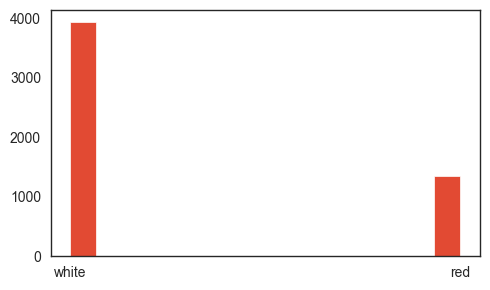

In [137]:
print("Категории в type")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3), squeeze=False)
plot_nominals(cleaned_wines, ["type"], axes)
plt.tight_layout()
plt.show()

Требуется дальнейшая предобработка данных - замена категориальных переменных на числовые (подготовка целевой переменной),а также  определение колонок с числовыми переменными, которые будем использовать в качестве признаков модели. Классы сильно несбалансированы, потребуется балансировка. Кроме того, порядок числовых признаков различается, потому, возможно, будем делать нормализацию

Тепловая карта корреляции позволит оценить важность признаков.

In [138]:
# Замена категориальной переменной type (тип вина) на числовую (0 и 1)
replace_dict = {'red': 0, 'white': 1}
cleaned_wines['type'] = cleaned_wines['type'].map(replace_dict)

Тепловая карта корреляции позволит оценить важность признаков.

In [86]:
def plot_correlation_map(df: pd.DataFrame) -> None:
  """построение тепловой карты"""
  corr = df.corr()
  _, ax = plt.subplots(figsize=(12, 10))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  _ = sns.heatmap(corr, cmap=cmap, square=True, cbar_kws={'shrink': .9},
                  ax=ax, annot=True, annot_kws={'fontsize':12})

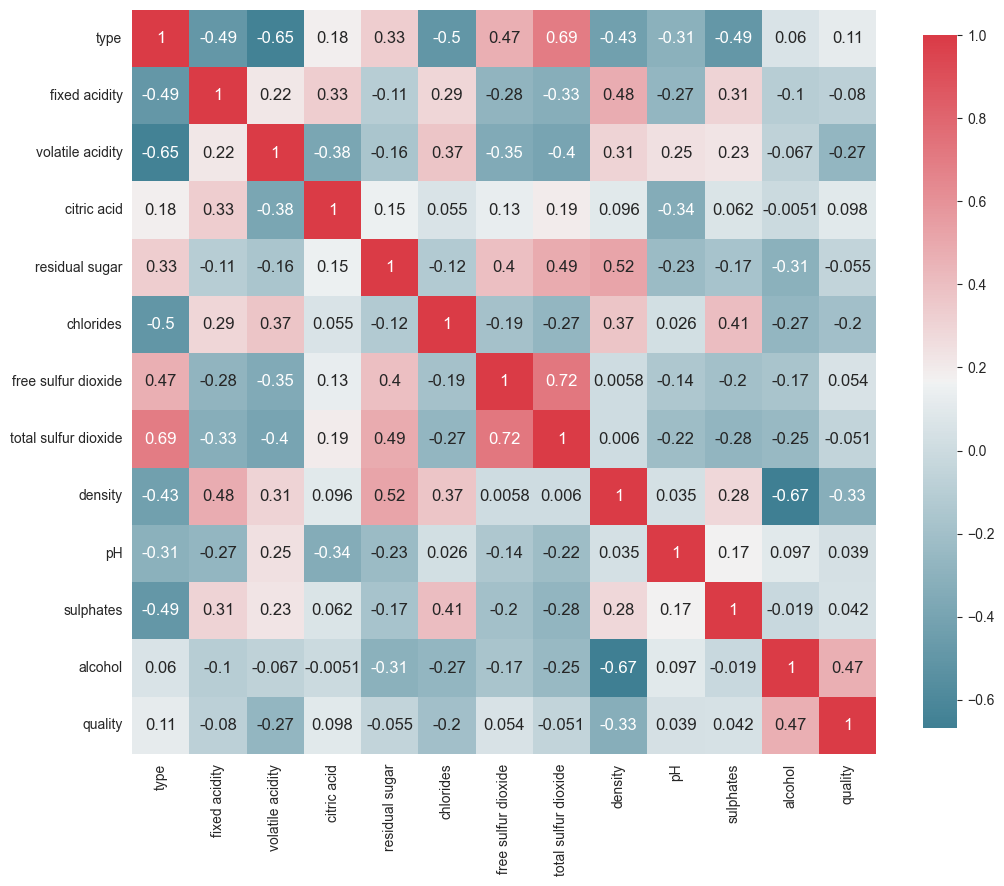

In [53]:
# карта корреляции для всего датасета
plot_correlation_map(cleaned_wines)

In [139]:
# Замена категориальной переменной quality (качество вина) на строковую 6, 5, 7, 8, 4, 3, 9
replace_dict1 = {6:'6', 5:'5', 7:'7', 8:'8', 4:'4', 3:'3', 9:'9'}
cleaned_wines['quality'] = cleaned_wines['quality'].map(replace_dict1)

Наибольшую корреляцию с типом вина имеют признаки: total sulfur dioxide, volatile_acidity,chlorides, sulfates,fixed_axidiry, density, residual shugar, наименьшую - alcogol и quality.  Пока нет уверенности, что все имеющиеся признаки позитивно влияют на конечный результат классификации. поэтому не будем использовать 2 последних признака

In [140]:
def build_features(df: pd.DataFrame) -> pd.DataFrame | None:
    # балансировка классов по типу оверсэмплинга, сохранение целевой переменной и  признаков модели
    # определяем колонки с числовыми признаками
    numeric_features =\
        df.drop(columns=['type']).columns.tolist()

    # Подготовка датафрейма для бинарной классификации вин по типу
    X = df[numeric_features]

    y = df['type']


    sm = SMOTE(random_state=42, k_neighbors=4)
    X, y = sm.fit_resample(X, y)
    y_tmp = y.to_frame()
    data = pd.concat([X, y_tmp], axis=1)  # датафрейм после оверсэмплинга.
    data.to_csv('data.csv',
                index=False, columns=data.columns)


    print('feature engineering complete')
    return data



In [141]:
data = build_features(cleaned_wines) # балансировка классов по типу оверсэмплинга, сохранение целевой переменной и  признаков модели  файлах

feature engineering complete


In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7884 entries, 0 to 7883
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         7884 non-null   float64
 1   volatile acidity      7884 non-null   float64
 2   citric acid           7884 non-null   float64
 3   residual sugar        7884 non-null   float64
 4   chlorides             7884 non-null   float64
 5   free sulfur dioxide   7884 non-null   float64
 6   total sulfur dioxide  7884 non-null   float64
 7   density               7884 non-null   float64
 8   pH                    7884 non-null   float64
 9   sulphates             7884 non-null   float64
 10  alcohol               7884 non-null   float64
 11  quality               7884 non-null   object 
 12  type                  7884 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 800.8+ KB


In [90]:
# сформируем вектор признаков.
X = data.drop(columns=['type', 'quality'])
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6


### Вывод

## Задание 3
Разбить выборку на тренировочную и тестовую. Тренировочная для обучения модели, тестовая для проверки ее качества.

In [121]:
y = data['type']
X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['alcohol']] = scaler.fit_transform(X_train[['alcohol']])
X_test_scaled[['alcohol']] = scaler.transform(X_test[['alcohol']])

print(f"Признаки обучающей выборки (X_train): {X_train_scaled.shape}")
print(f"Признаки тестовой выборки (X_test): {X_test_scaled.shape}")

Признаки обучающей выборки (X_train): (6307, 11)
Признаки тестовой выборки (X_test): (1577, 11)


### Вывод

Обучающая выборка (`X_train`) используется для того, чтобы модель научилась находить зависимости между признаками и целевой переменной.

Тестовая выборка (`X_test`) используется для проверки качества обученной модели. Модель видит эти данные впервые и это позволяет объективно оценить, насколько хорошо модель обобщает знания на новые, невидимые данные.

## Задание 4
Применить алгоритмы классификации: логистическая регрессия, SVM, KNN. Построить матрицу ошибок по результатам работы моделей (использовать confusion_matrix из sklearn.metrics).

In [108]:
def eval_model(X, y, X_test, y_test, random_seed, model, flag):
  """
  Служебная функция. выполняет:
    - расчет метрик качества модели бинарной классификации вина по типу в виде classification_report
    - построение confusion matrix
    - кросс-валидацию модели
    args:
    X: pd.DataFrame - датафрейм признаков,
    y: np.ndarray - массив целевой переменной,
    X_test: pd.DataFrame - тестовый датафрейм
    y_test: np.ndarray - тестовый массив целевой переменной,
    random_seed - фиксатор генератора случ.чисел,
    model - модель классификатора,
    flag - признак печати результатов (True/False)
  """
  num_folds = 9
  scoring = 'r2'
  kfold = StratifiedKFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  target_names = ['red', 'white']
  # Отчет полностью
  report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True )
  a = report['accuracy']
  scoring = ['precision_macro', 'recall_macro']
  cv_results = cross_validate(model, X, y, cv=kfold, scoring=scoring)
  if flag:
    print(
      "Classification report\n")
    print(
      f"{classification_report(y_test, y_pred, target_names=target_names)}\n"
    )
    # Confusion matrix
    fig, ax = plt.subplots(figsize=(6, 3))

    cm = confusion_matrix(y_test, y_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=target_names)
    cmp.plot(ax=ax, xticks_rotation='vertical')
    plt.show()

  # return cv_results
  return report['macro avg']

In [109]:
results = dict()

### Задание 4.1
Логистическая Регрессия

Classification report

              precision    recall  f1-score   support

         red       0.98      0.98      0.98       779
       white       0.98      0.98      0.98       798

    accuracy                           0.98      1577
   macro avg       0.98      0.98      0.98      1577
weighted avg       0.98      0.98      0.98      1577




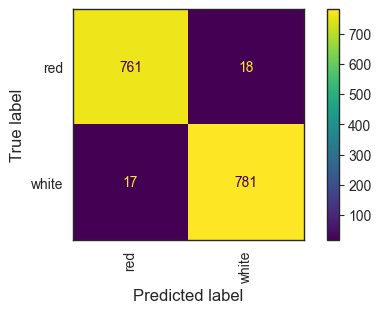

In [115]:
model = LogisticRegression(random_state=42)
results['baseline'] = eval_model(X, y, X_test, y_test, 42, model, flag=True)

### Задание 4.2
 SVM

Classification report

              precision    recall  f1-score   support

         red       0.94      0.85      0.89       779
       white       0.86      0.94      0.90       798

    accuracy                           0.90      1577
   macro avg       0.90      0.90      0.90      1577
weighted avg       0.90      0.90      0.90      1577




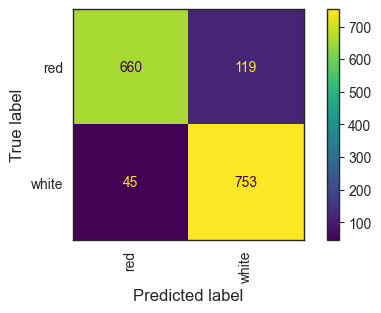

In [116]:
model = svm.SVC(random_state=42)
results['svm'] = eval_model(X, y, X_test, y_test, 42, model, flag=True)

### Задание 4.3
KNN

Classification report

              precision    recall  f1-score   support

         red       0.94      0.96      0.95       779
       white       0.96      0.94      0.95       798

    accuracy                           0.95      1577
   macro avg       0.95      0.95      0.95      1577
weighted avg       0.95      0.95      0.95      1577




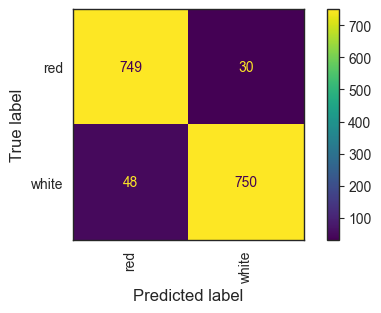

In [117]:
model = KNeighborsClassifier(n_neighbors=3)
results['KNN'] = eval_model(X, y, X_test, y_test, 42, model, flag=True)

## Задание 5
Сравнить результаты классификации, используя accuracy, precision, recall и f1-меру (можно использовать classification_report из sklearn.metrics). Сделать выводы.

In [119]:
res=pd.DataFrame.from_dict(results)
res.drop('support', axis=0, inplace=True)
res.head()

,baseline,svm,KNN
precision,0.977810,0.899851,0.950656
recall,0.977795,0.895425,0.950669
f1-score,0.977802,0.895642,0.950539


### Выводы
* Baseline модель является явным лидером, обеспечивая максимальную надежность предсказаний

* Высокая стабильность baseline и KNN моделей подтверждается практически идентичными значениями precision и recall

* SVM требует дополнительной настройки или может быть менее подходящей для данной задачи

* Все модели демонстрируют исключительно высокое качество классификации (>89.5%), что указывает на хорошую разделимость классов в данных